In [1]:
import scanpy as sc
import sys
sys.path.append("../")
import trvaep
import numpy as np

## loading and preparing data 

In [2]:
adata = sc.read("../data/haber_count.h5ad", backup_url="shorturl.at/imuEP")
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var['highly_variable']]
n_conditions = adata.obs["condition"].unique().shape[0]
condition_key = "condition"

In [3]:
adata_train = adata[~((adata.obs["cell_label"] == "TA")
                      & (adata.obs["condition"] == "Hpoly.Day10"))]

In [5]:
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohammad/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


/home/mohammad/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


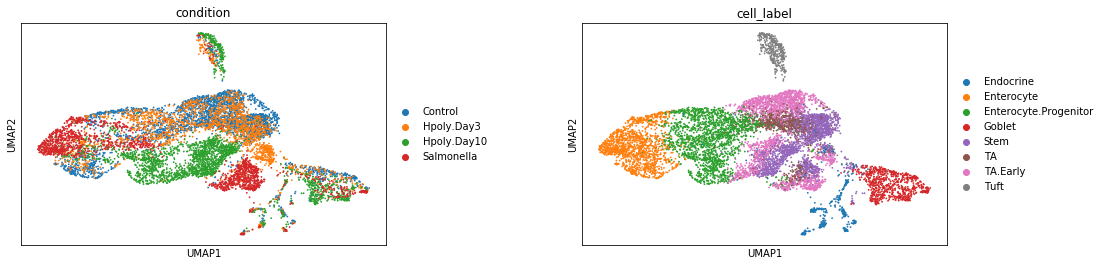

In [6]:
sc.pl.umap(adata_train, color=["condition", "cell_label"], wspace=.4)

## creating model object 

In [4]:
model = trvaep.CVAE(adata_train.n_vars, num_classes=n_conditions,
            output_activation="ReLU", encoder_layer_sizes=[64, 32], decoder_layer_sizes=[32, 64], use_mmd=True, beta=1)

### Make a trainer object 


In [10]:
trainer = trvaep.Trainer(model, adata_train, condition_key=condition_key)

In [11]:
trainer.train_trvae(300, 512, early_patience=50, )

Epoch 00/300 Batch 0000/15, Loss:  276.8673, rec_loss:  275.2473, KL_loss:    0.0007, MMD_loss:     1.6193
Epoch 00/300 Batch 0015/15, Loss:  215.1389, rec_loss:  213.6713, KL_loss:    0.0014, MMD_loss:     1.4662
Epoch 01/300 Batch 0000/15, Loss:  221.9079, rec_loss:  220.3529, KL_loss:    0.0014, MMD_loss:     1.5537
Epoch 01/300 Batch 0015/15, Loss:  188.9714, rec_loss:  187.4962, KL_loss:    0.0022, MMD_loss:     1.4730
Epoch 02/300 Batch 0000/15, Loss:  195.1207, rec_loss:  193.7375, KL_loss:    0.0021, MMD_loss:     1.3811
Epoch 02/300 Batch 0015/15, Loss:  161.5038, rec_loss:  160.0641, KL_loss:    0.0029, MMD_loss:     1.4368
Epoch 03/300 Batch 0000/15, Loss:  166.0620, rec_loss:  164.6515, KL_loss:    0.0030, MMD_loss:     1.4075
Epoch 03/300 Batch 0015/15, Loss:  149.8323, rec_loss:  148.6716, KL_loss:    0.0042, MMD_loss:     1.1565
Epoch 04/300 Batch 0000/15, Loss:  148.7834, rec_loss:  147.5324, KL_loss:    0.0042, MMD_loss:     1.2468
Epoch 04/300 Batch 0015/15, Loss:  14

## visualizing the MMD latent space

You can use MMD layer representation for batch-removal

`c` can be the batch or the condition that you want your data to be mapped on it.

/home/mohammad/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
... storing 'cell_label' as categorical
... storing 'condition' as categorical
/home/mohammad/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


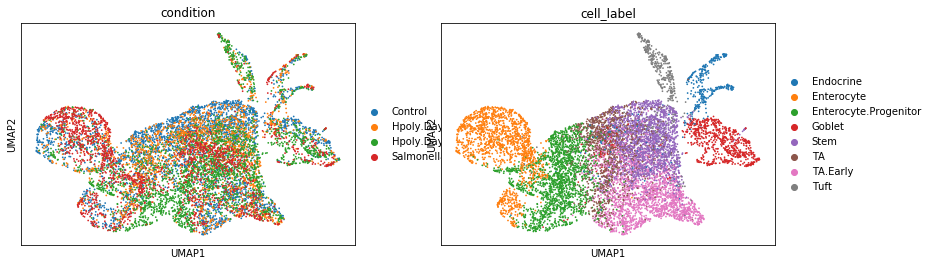

In [12]:
latent_y = model.get_y(
    adata.X, c=model.label_encoder.transform(np.tile(np.array("Control"), len(adata))))
adata_latent = sc.AnnData(latent_y)
adata_latent.obs["cell_label"] = adata.obs["cell_label"].tolist()
adata_latent.obs[condition_key] = adata.obs[condition_key].tolist()
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color=[condition_key, "cell_label"])

## Making prediction

... storing 'barcode' as categorical
... storing 'cell_label' as categorical
... storing 'condition' as categorical


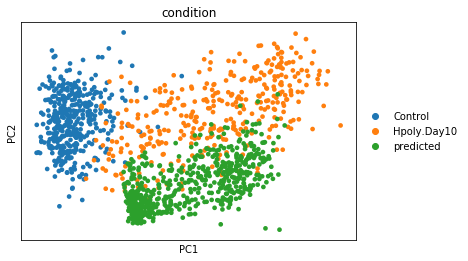

/home/mohammad/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


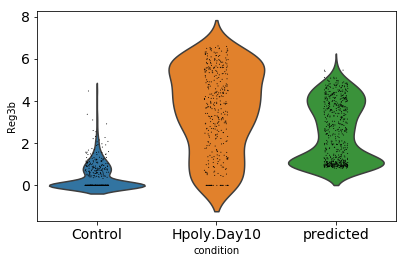

In [13]:
ground_truth = adata[((adata.obs["cell_label"] == "TA")
                      & (adata.obs["condition"].isin(["Hpoly.Day10", "Control"])))]
adata_source = adata[(adata.obs["cell_label"] == "Stem") &
                     (adata.obs["condition"] == "Hpoly.Day10")]
predicted_data = model.predict(x=adata_source.X, y=adata_source.obs["condition"].tolist(),
                               target="Hpoly.Day10")
adata_pred = sc.AnnData(predicted_data)
adata_pred.obs["condition"] = np.tile("predicted", len(adata_pred))
adata_pred.var_names = adata_source.var_names.tolist()
all_adata = ground_truth.concatenate(adata_pred)
sc.tl.pca(all_adata)
sc.pl.pca(all_adata, color=["condition"])
sc.pl.violin(all_adata, keys="Reg3b", groupby="condition")

### Get batch corrected data in output space for all data 

`target` can be the batch or the condition that you want your data to be mapped on it.

In [14]:
batch_removed = model.predict(x=adata.X, y=adata.obs[condition_key].tolist(),
                               target="Control")

In [15]:
corrected = sc.AnnData(batch_removed)
corrected.obs["cell_label"] = adata.obs["cell_label"].tolist()
corrected.obs[condition_key] = adata.obs[condition_key].tolist()

In [16]:
sc.pp.neighbors(corrected)
sc.tl.umap(corrected)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'cell_label' as categorical
... storing 'condition' as categorical


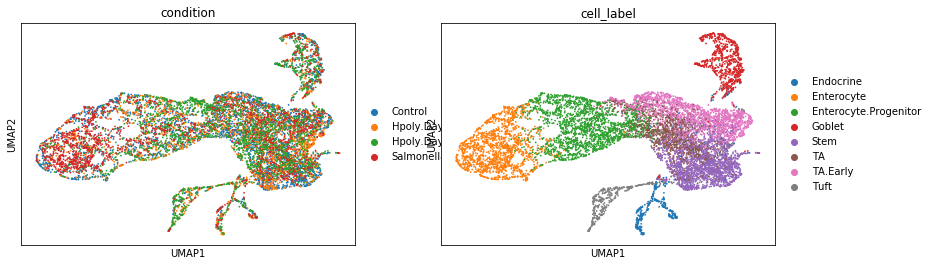

In [17]:
sc.pl.umap(corrected, color=[condition_key, "cell_label"])